## Read Data

In [8]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from lucid_project.analysis import XYC, Clustering

## define metadata
particles = {"109883583_3_0":"32","109883583_2_0":"32","713576296_0_0":"32", "1393200002_16_0":"6", "1686524462_0_0":"122"}

## data to be used
frame_name, index = list(particles.items())[0]

## data source
frame = XYC.read("./sample_data/xyc_files/"+frame_name+".txt", "frame") ## returns Frame object
print(frame)

## true for energy, false for Time-Over-Threshold
frame.set_energy(True)


True

## Frame Object

### Frame Plot

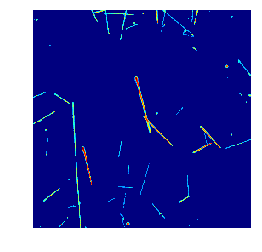

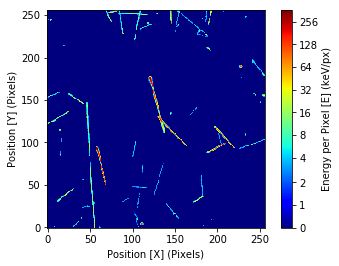

'Successful'

In [9]:
## image of frame without axes
frame.image().show()
## image of frame with axes (paper style)
frame.plot().show()

#### TO SAVE IMAGES AND PLOTS
frame.image().save("./output/frame_plots/frame_img.png")
frame.plot().save("./output/frame_plots/frame_plt.png")

### Clustering Plot

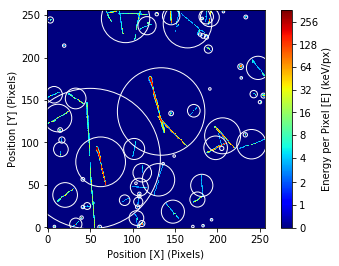

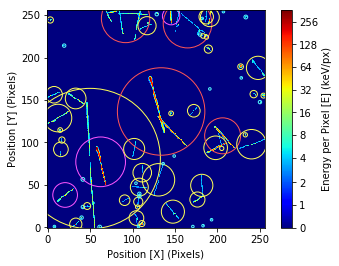

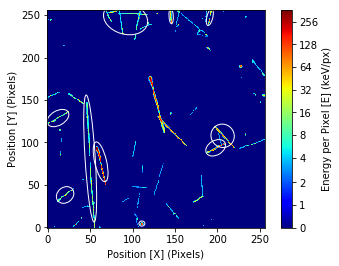

'Successful'

In [10]:
## plot of clusters
cluster_plot = frame.cluster().plot(patch_type=0, classify=False)
cluster_plot.show()
cluster_plot.save("./output/frame_plots/clustering_0_0.png")

cluster_plot = frame.cluster().plot(patch_type=0, classify=True)
cluster_plot.show()
cluster_plot.save("./output/frame_plots/clustering_1_0.png")

## filter particles by total energy
attributes = {"energy_sum":[500, 10000]}
filtered_frame = frame.cluster().filtrate(attributes).plot(patch_type=1)
filtered_frame.show()
filtered_frame.save("./output/frame_plots/filtered_frame_0_1.png")


### Cluster Plot

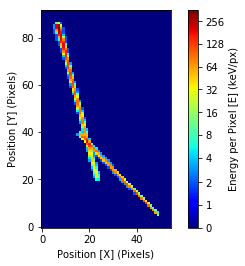

In [11]:
# list of cluster objects
clusters = frame.cluster().list
cluster = clusters[int(index)]
cluster.plot().show()

## Cluster Attributes

In [12]:
## the cluster as a list of pixels [(x1,y1,c1), ..., (xn,yn,cn)]
pixels = cluster.pixels
print(pixels[:5])

## useful shape metrics - (Measured in pixels, density = pixels in bounding box)
## [num_pixels, density, radius, curvature_radius, line_residual, circle_residual, width, avg_neighbours]
metrics = cluster.calculate()
print(metrics)

## default params for classify, note*: c_val=true not yet supported
## as there are no classifiers that can handle energy/TOT analysis
classification = cluster.classify(algorithm="neural", c_val=False)
print(classification)

[(119, 79, 3), (119, 80, 3), (120, 78, 9), (120, 79, 217), (120, 80, 203)]
[293, 0.03733270197929848, 49.9820612207258, 89.85053001724458, 4753.142677399504, 1388.9498944800885, 2.9310515897501968, 5.747440273037543]
others


## LUCID Data API

In [13]:
from lucid_project.api import data_api

all_runs = data_api.get_runs()
print(all_runs[:5])

['2015-05-04', '2015-05-28', '2015-05-20', '2015-05-12', '2015-04-26']


In [14]:
files = []
## get first two files of each run
for run in all_runs:
    files += data_api.get_data_files(run)[:2]
print(files[:5])

[{'id': '533354612', 'timestamp': '1430842330', 'latitude': '40.3133888888889', 'longitude': '82.0262222222222', 'config': '0129', 'run': '2015-05-04', 'num_frames': '236', 'active_detectors': '0,1,3'}, {'id': '533354658', 'timestamp': '1430883730', 'latitude': '71.89675', 'longitude': '-110.008055555556', 'config': '0129', 'run': '2015-05-04', 'num_frames': '216', 'active_detectors': '0,1,3'}, {'id': '1882802768', 'timestamp': '1432919531', 'latitude': '-25.3618888888889', 'longitude': '79.5341111111111', 'config': '0145', 'run': '2015-05-28', 'num_frames': '205', 'active_detectors': '0,1,3'}, {'id': '1882802688', 'timestamp': '1432847531', 'latitude': '-34.0180555555556', 'longitude': '-170.204472222222', 'config': '0145', 'run': '2015-05-28', 'num_frames': '238', 'active_detectors': '0,1,3'}, {'id': '684977460', 'timestamp': '1432271530', 'latitude': '-25.6138888888889', 'longitude': '-100.837277777778', 'config': '0140', 'run': '2015-05-20', 'num_frames': '178', 'active_detectors':

### Usage Example

In [ ]:
file_num = 1
total_files = len(files)

for file in files:
    
    if (file_num % 40 == 0):
        print('ANALYSING FILE', file_num, '/', total_files)
    
    file_num += 1
    e,p,g,m,o,a = 0,0,0,0,0,0
    
    frames = data_api.get_frames(file['id'])[:10]
    num_frames = len(frames)
    
    ## don't use less than 10 frames per file (for fair test)
    if num_frames < 10:
        continue
    
    mid = int(round(num_frames/2))
    lat, lng = frames[mid].latitude, frames[mid].longitude

    file_id = file['id']
    file_timestamp = file['timestamp']
    
    for frame in frames:
        clusters = Clustering(frame.channels[0]).find().list
        for cluster in clusters:
            c = cluster.classify()
            if c == 'beta':
                e += 1
            elif c == 'proton':
                p += 1
            elif c == 'gamma':
                g += 1
            elif c == 'muon':
                m += 1
            elif c == 'others':
                o += 1
            elif c == 'alpha':
                a += 1
            else:
                pass
            
    counts_file = open('./sample_data/map_data/counts.csv', 'a')
    counts_file.write(str(file_id) + ',' + str(file_timestamp) + ',' + str(lat) + ',' + str(lng) + ',' + str(num_frames) + ','
             + str(e) + ',' + str(p) + ',' + str(g) + ',' + str(m) + ',' + str(o) + ',' + str(a) + '\n')
    counts_file.close()

## Map Maker

In [ ]:
from lucid_project.tools.mapper import map_make

def norm(counts, num_frames):
    count = (float(counts) / float(num_frames))
    surface_area = 1.98 ## cm^2
    exposure_time = 0.3 ## s
    count = round( (count / exposure_time) / surface_area )
    return count

def data_read(file):
    data = open(file).readlines()
    datapoints = []

    for datum in data:
        if datum:
            ## fid, tim, lat, lng, num_frames, det, len_det, e, p, g, m, a, o = datum.split(",")
            ## total_frames = round(int(len_det) * float(num_frames))
            fid, tim, lat, lng, num_frames, e, p, g, m, a, o = datum.split(",")
            total_frames = num_frames
            datapoints.append((float(lat), float(lng),
                              norm(e, total_frames),
                              norm(p, total_frames),
                              norm(g, total_frames),
                              norm(m, total_frames),
                              norm(a, total_frames),
                              norm(o, total_frames)
                              ))
    return datapoints

file_path = "./sample_data/map_data/counts_example.csv"
datapoints = data_read(file_path)
## datapoints = [[lat1, lng1, da1, db1, dc1], ..., [latN, lngN, daN, dbN, dcN]]
map_make(datapoints, labels = ["Electron", "Proton", "Gamma", "Muon", "Alpha", "Other"] )